https://gene.sfari.org/database/human-gene/

Dado um gene **X**, como prever se ele é **sindrômico** baseado em suas características, como a numeração do cromossomo, 

In [84]:
import pandas as pd
import math
import numpy as np

from collections import Counter
import missingno as msno

import seaborn as sns
import matplotlib.pyplot as plt
from keras import layers, models
from keras.models import Sequential
from keras.layers import Dense
import pydot
import graphviz
from tensorflow.keras.utils import plot_model
import visualkeras

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from matplotlib.cbook import boxplot_stats

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.cluster import KMeans
from sklearn.svm import SVC

from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import AdaBoostClassifier

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve, auc, roc_auc_score, RocCurveDisplay, classification_report, confusion_matrix
from sklearn.metrics import silhouette_score, jaccard_score, silhouette_samples
from sklearn.model_selection import KFold

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

In [2]:
df = pd.read_csv("SFARI-Gene_genes_08-19-2024release_08-26-2024export.csv")

## Pré-processamento

In [3]:
df.columns

Index(['status', 'gene-symbol', 'gene-name', 'ensembl-id', 'chromosome',
       'genetic-category', 'gene-score', 'syndromic', 'eagle',
       'number-of-reports'],
      dtype='object')

- **chromosome:** This section lists the chromosomal band in which a gene is found.
- **genetic-category:** Genetic Category – This section denotes which of the four genetic categories a gene falls under.
- **gene-score:** This section shows the assigned gene score category that assesses the evidence linking it to ASD. The scoring criteria can be found [here](https://gene.sfari.org/about-gene-scoring/eagle-score/).
- **eagle:** First presented in Schaaf et al. (2020), the **EAGLE (Evaluation of Autism Gene Link Evidence) scoring** system implements and expands on pre-existing frameworks (primarily the ClinGen (Clinical Genome Resource) framework) with the objective to evaluate evidence regarding the relevance of a gene with respect to ASD, rather than potentially with a broad range of neurodevelopmental phenotypes.

OBS: As outras colunas são identificadores únicos

### Remoção de colunas com instâncias de identificam um único gene

In [4]:
df_cut = df.drop(['status', 'gene-symbol', 'gene-name', 'ensembl-id'], axis=1)
df_cut

,chromosome,genetic-category,gene-score,syndromic,eagle,number-of-reports
0,16,"Rare Single Gene Mutation, Genetic Association",2.0,0,NaN,8
1,17,Rare Single Gene Mutation,2.0,0,NaN,3
2,7,"Rare Single Gene Mutation, Functional",2.0,0,NaN,11
3,19,Rare Single Gene Mutation,2.0,0,NaN,6
4,4,Rare Single Gene Mutation,1.0,0,1.4,3
...,...,...,...,...,...,...
1186,15,Rare Single Gene Mutation,2.0,0,NaN,4
1187,2,"Rare Single Gene Mutation, Genetic Association...",2.0,0,NaN,16
1188,4,"Rare Single Gene Mutation, Genetic Association",2.0,0,NaN,3
1189,5,"Rare Single Gene Mutation, Syndromic, Genetic ...",NaN,1,NaN,6


### Remoção de dados faltantes

In [5]:
df_cut[df_cut['eagle'] > 0]

,chromosome,genetic-category,gene-score,syndromic,eagle,number-of-reports
4,4,Rare Single Gene Mutation,1.0,0,1.40,3
8,7,"Rare Single Gene Mutation, Syndromic",1.0,1,1.00,10
17,20,"Rare Single Gene Mutation, Syndromic, Functional",1.0,1,41.50,87
19,22,"Rare Single Gene Mutation, Syndromic",1.0,1,0.35,9
21,X,"Rare Single Gene Mutation, Syndromic",1.0,0,8.70,21
...,...,...,...,...,...,...
1139,10,"Rare Single Gene Mutation, Syndromic",1.0,1,15.00,30
1141,4,"Rare Single Gene Mutation, Syndromic, Functional",1.0,0,17.20,24
1175,20,"Rare Single Gene Mutation, Syndromic",1.0,1,4.50,8
1179,9,"Rare Single Gene Mutation, Syndromic, Functional",1.0,1,10.60,13


<Axes: >

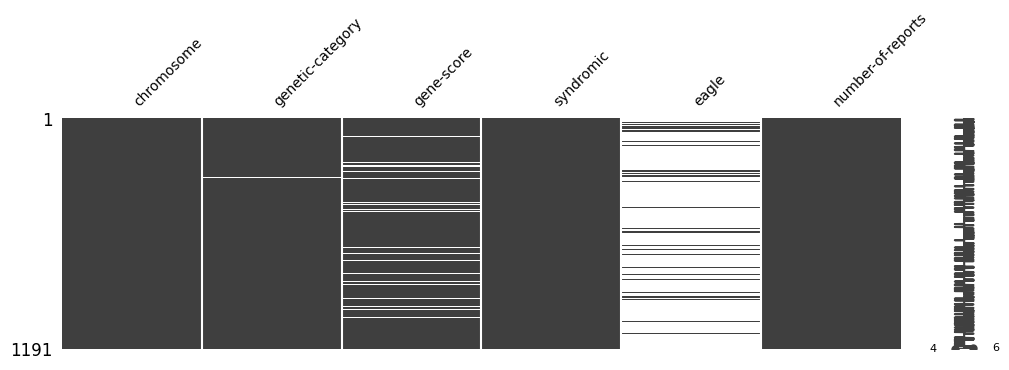

In [6]:
msno.matrix(df_cut, figsize=(12,3), fontsize=10)

In [7]:
df_clean = df_cut.dropna()

In [8]:
Counter(df_clean['genetic-category'])

Counter({'Rare Single Gene Mutation, Syndromic, Functional': 47,
         'Rare Single Gene Mutation': 44,
         'Rare Single Gene Mutation, Syndromic': 39,
         'Rare Single Gene Mutation, Syndromic, Genetic Association, Functional': 26,
         'Rare Single Gene Mutation, Functional': 11,
         'Rare Single Gene Mutation, Genetic Association, Functional': 8,
         'Rare Single Gene Mutation, Genetic Association': 4,
         'Rare Single Gene Mutation, Syndromic, Genetic Association': 3})

In [9]:
Counter(df_clean['chromosome'])

Counter({'X': 17,
         '2': 16,
         '17': 15,
         '1': 12,
         '11': 12,
         '9': 11,
         '19': 9,
         '3': 9,
         '7': 8,
         '16': 8,
         '4': 7,
         '10': 7,
         '12': 6,
         '6': 6,
         '8': 6,
         '5': 6,
         '15': 5,
         '18': 5,
         '14': 5,
         '20': 4,
         '22': 4,
         '21': 4})

### Tratando variáveis categóricas

In [10]:
df_clean.dtypes

chromosome            object
genetic-category      object
gene-score           float64
syndromic              int64
eagle                float64
number-of-reports      int64
dtype: object

#### As colunas **chromosome** e **genetic-category** são tratadas como categóricas nominais (não-ordinários).
Dada a alta cardinalidade para as diferentes instâncias de **chromosome**, utiliza-se o agrupamento de instâncias baseado em sua frequência

In [11]:
df_grouped = df_clean.copy()

# Step 1: Calculate frequency of each unique category
categories_df = df_grouped['chromosome'].value_counts().reset_index()
categories_df.columns = ['chromosome', 'count']

# Step 2: Sort categories by count (frequency) in descending order
categories_df = categories_df.sort_values('count', ascending=False).reset_index(drop=True)

# Step 3: Divide into groups based on sorted frequency
num_groups = 4  # Define the number of groups you want
categories_df['group'] = pd.qcut(categories_df.index, num_groups, labels=False)

chromosome_to_group = categories_df.set_index('chromosome')['group'].to_dict()
df_grouped['chromosome_group'] = df_grouped['chromosome'].map(chromosome_to_group)

# Step 5: Create one-hot encoded columns based on the groups
for i in range(num_groups):
    df_grouped[f'chromosome_{i}'] = (df_grouped['chromosome_group'] == i).astype(int)

# Step 6: Drop the intermediate 'chromosome_group' column if not needed
df_grouped = df_grouped.drop(columns=['chromosome_group', 'chromosome'])

# Print or inspect the resulting DataFrame
#print(categories_df)

In [12]:
df_grouped.head()

,genetic-category,gene-score,syndromic,eagle,number-of-reports,chromosome_0,chromosome_1,chromosome_2,chromosome_3
4,Rare Single Gene Mutation,1.0,0,1.40,3,0,0,1,0
8,"Rare Single Gene Mutation, Syndromic",1.0,1,1.00,10,0,1,0,0
17,"Rare Single Gene Mutation, Syndromic, Functional",1.0,1,41.50,87,0,0,0,1
19,"Rare Single Gene Mutation, Syndromic",1.0,1,0.35,9,0,0,0,1
21,"Rare Single Gene Mutation, Syndromic",1.0,0,8.70,21,1,0,0,0


In [13]:
df_encoded = pd.get_dummies(df_grouped, columns=['genetic-category'], dtype=int)

In [14]:
df_encoded.columns = df_encoded.columns.str.replace('genetic-category_Rare Single Gene Mutation', 'rare_sgm').str.replace(" ", "").str.replace(",", "")

In [15]:
df_encoded.head()

,gene-score,syndromic,eagle,number-of-reports,chromosome_0,chromosome_1,chromosome_2,chromosome_3,rare_sgm,rare_sgmFunctional,rare_sgmGeneticAssociation,rare_sgmGeneticAssociationFunctional,rare_sgmSyndromic,rare_sgmSyndromicFunctional,rare_sgmSyndromicGeneticAssociation,rare_sgmSyndromicGeneticAssociationFunctional
4,1.0,0,1.40,3,0,0,1,0,1,0,0,0,0,0,0,0
8,1.0,1,1.00,10,0,1,0,0,0,0,0,0,1,0,0,0
17,1.0,1,41.50,87,0,0,0,1,0,0,0,0,0,1,0,0
19,1.0,1,0.35,9,0,0,0,1,0,0,0,0,1,0,0,0
21,1.0,0,8.70,21,1,0,0,0,0,0,0,0,1,0,0,0


### Removendo outliers
- Using IQR (Interquartile Range)
- Após as etapas anteriores, restou remover a coluna **gene-score**

<Axes: xlabel='variable', ylabel='value'>

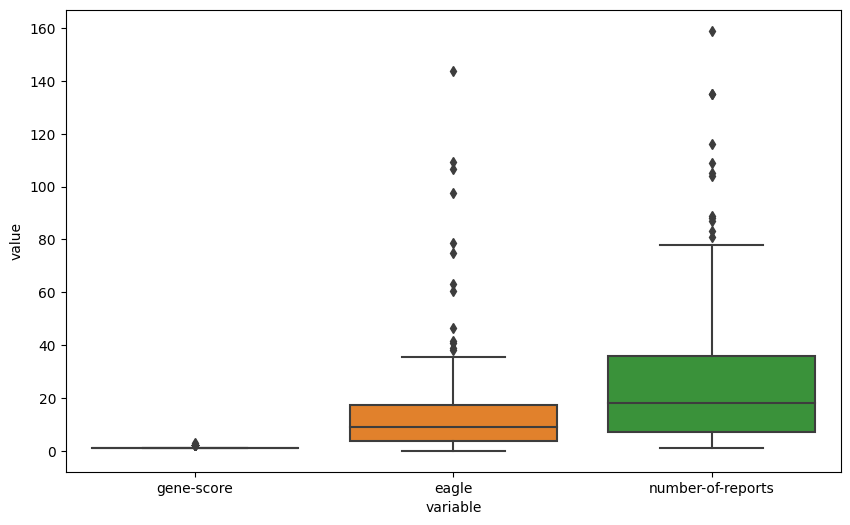

In [16]:
# Subset of columns to plot
columns_to_plot = [ 'gene-score', 'eagle', 'number-of-reports']

# Melt the DataFrame to long format for seaborn
df_melted = df_encoded[columns_to_plot].melt()

# Plotting boxplot with seaborn
plt.figure(figsize=(10, 6))
sns.boxplot(x='variable', y='value', data=df_melted)

In [17]:
Counter(df_encoded['gene-score'])

Counter({1.0: 158, 2.0: 23, 3.0: 1})

In [18]:
def remove_outliers_iqr(df, columns):
    df_cleaned = df.copy()
    
    for col in columns:
        if col in df_cleaned.columns:
            Q1 = df_cleaned[col].quantile(0.25)
            Q3 = df_cleaned[col].quantile(0.75)
            IQR = Q3 - Q1

            lower_bound = Q1 - 1.0 * IQR
            upper_bound = Q3 + 0.70 * IQR

            df_cleaned = df_cleaned[(df_cleaned[col] >= lower_bound) & (df_cleaned[col] <= upper_bound)]
        else:
            print(f"Column '{col}' not found in DataFrame.")
    
    return df_cleaned

In [19]:
df_final = remove_outliers_iqr(df_encoded, ['gene-score', 'eagle','number-of-reports'])

<Axes: xlabel='variable', ylabel='value'>

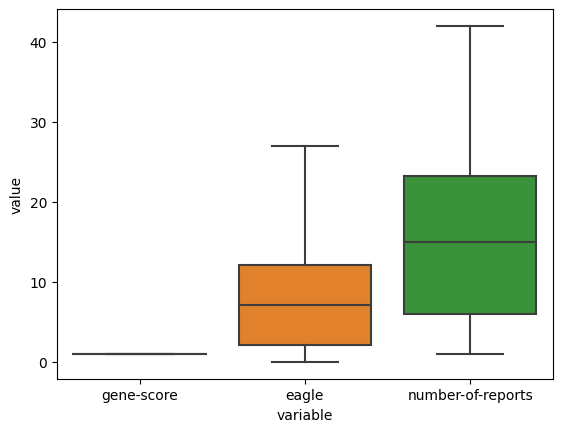

In [20]:
columns_to_plot = [ 'gene-score', 'eagle', 'number-of-reports' ]
df_melted = df_final[columns_to_plot].melt()
sns.boxplot(x='variable', y='value', data=df_melted)

In [21]:
Counter(df_final['gene-score'])

Counter({1.0: 120})

In [22]:
df_final = df_final.drop(['gene-score'], axis=1)
df_final.columns

Index(['syndromic', 'eagle', 'number-of-reports', 'chromosome_0',
       'chromosome_1', 'chromosome_2', 'chromosome_3', 'rare_sgm',
       'rare_sgmFunctional', 'rare_sgmGeneticAssociation',
       'rare_sgmGeneticAssociationFunctional', 'rare_sgmSyndromic',
       'rare_sgmSyndromicFunctional', 'rare_sgmSyndromicGeneticAssociation',
       'rare_sgmSyndromicGeneticAssociationFunctional'],
      dtype='object')

### Normalização

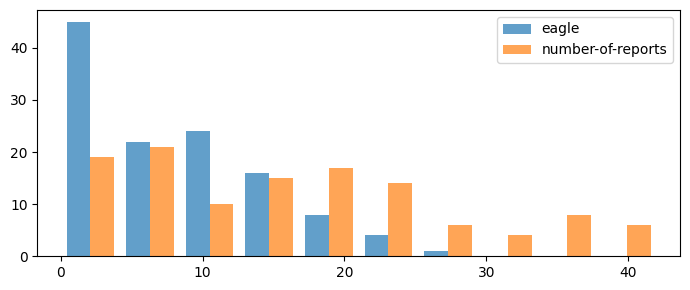

In [23]:
fig, axes = plt.subplots(figsize=(7, 3))

axes.hist([df_final['eagle'], df_final['number-of-reports']], bins=10, alpha=0.7, label=['eagle', 'number-of-reports'])
plt.legend(loc='upper right')
plt.tight_layout()

plt.show()

In [24]:
scaler = MinMaxScaler() # 0 - 1
df_norm = pd.DataFrame(scaler.fit_transform(df_final), columns = df_final.columns)

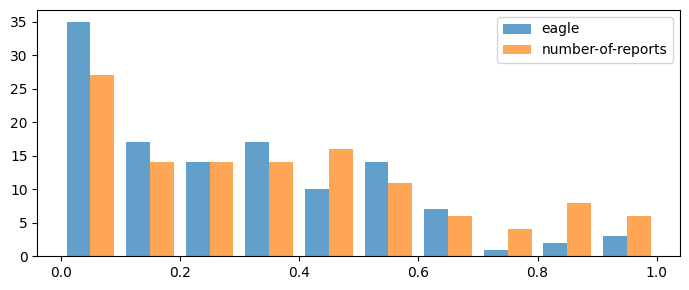

In [25]:
fig, axes = plt.subplots(figsize=(7, 3))

axes.hist([df_norm['eagle'], df_norm['number-of-reports']], bins=10, alpha=0.7, label=['eagle', 'number-of-reports'])
plt.legend(loc='upper right')
plt.tight_layout()

plt.show()

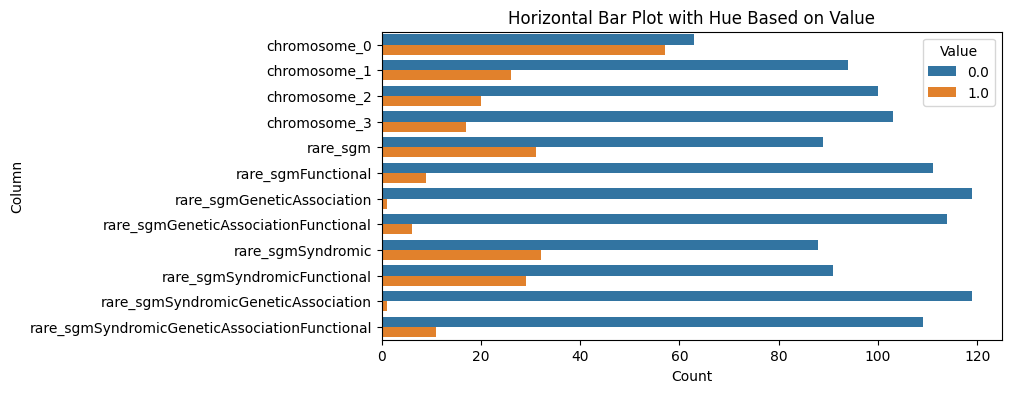

In [26]:
# Specify the columns you want to plot
columns_to_plot = ['chromosome_0',
       'chromosome_1', 'chromosome_2', 'chromosome_3', 'rare_sgm',
       'rare_sgmFunctional', 'rare_sgmGeneticAssociation',
       'rare_sgmGeneticAssociationFunctional', 'rare_sgmSyndromic',
       'rare_sgmSyndromicFunctional', 'rare_sgmSyndromicGeneticAssociation',
       'rare_sgmSyndromicGeneticAssociationFunctional'] 

# Step 1: Filter the DataFrame to keep only the selected columns
df_filtered = df_norm[columns_to_plot]

# Step 1: Reshape DataFrame to long format
df_long = df_filtered.melt(var_name='column', value_name='value')

# Step 3: Create a new column for the hue category
df_long['hue'] = df_long['value'].astype(str)  # Convert 0/1 to string for hue

# Step 4: Aggregate data for plotting
plot_data = df_long.groupby(['column', 'hue']).size().reset_index(name='count')

# Step 5: Plot
plt.figure(figsize=(8, 4))
sns.barplot(data=plot_data, y='column', x='count', hue='hue', errorbar=None)

# Customize the plot
plt.title('Horizontal Bar Plot with Hue Based on Value')
plt.xlabel('Count')
plt.ylabel('Column')
plt.legend(title='Value')

# Show the plot
plt.show()

In [27]:
df_norm = df_norm.drop(['rare_sgmGeneticAssociation', 'rare_sgmSyndromicGeneticAssociation'], axis=1)

### Resultado após transformações no dataset

In [28]:
df_norm.shape

(120, 13)

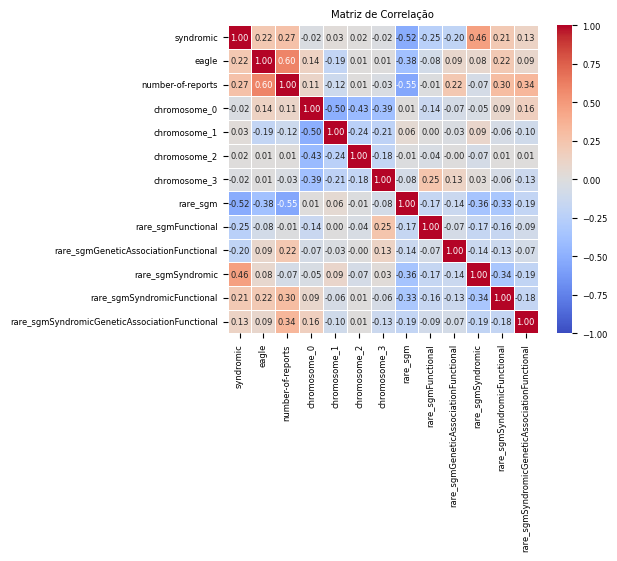

In [29]:
correlation_matrix = df_norm.corr()

plt.rcParams.update({'font.size': 6})
plt.figure(figsize=(5, 4))

sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap='coolwarm',
    fmt='.2f',
    linewidths=0.5,
    vmin=-1, 
    vmax=1    
)
plt.title('Matriz de Correlação')
plt.show()

## Modelagem

### Supervisionado

In [30]:
X = df_norm.drop(columns=['syndromic'])
y = df_norm['syndromic']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [31]:
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

syndromic
0.0    0.5625
1.0    0.4375
Name: proportion, dtype: float64
syndromic
0.0    0.583333
1.0    0.416667
Name: proportion, dtype: float64


#### K-Nearest Neighbors

- Acurácia do modelo (VP+VN/n)

In [32]:
# Métrica de distância manhattan, pois não considera correlação, fator pouco evidente
knn = KNeighborsClassifier(n_neighbors=3, metric='manhattan')

knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

print("\nClassification Report:\n", classification_report(y_test, y_pred))
# Recall para valor prositivo vale como revocação/sensibilidade
# Recall para valor negativo vale como especificidade
# OBS: Métricas muito utilizadas na bioestatística para testes de diagnóstico


Classification Report:
               precision    recall  f1-score   support

         0.0       0.89      0.57      0.70        14
         1.0       0.60      0.90      0.72        10

    accuracy                           0.71        24
   macro avg       0.74      0.74      0.71        24
weighted avg       0.77      0.71      0.71        24



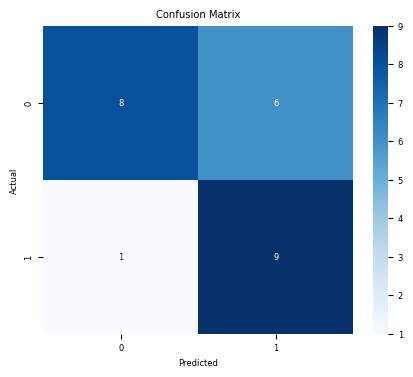

In [33]:
# Matriz de Confusão
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

- Validação cruzada (K-fold)

- Curva ROC (diferentes valores de K)
    - O número de K's interfere na suavização, podendo reduzir o risco de overfitting com um número suficientemente grande
    - Também pode supersuavizar, abstraindo a estrutura local dos dados, uma das vantagens do KNN


3:Cross-Validation Accuracy: 0.71 ± 0.03
3:Cross-Validation Precision: 0.66 ± 0.04
3:Cross-Validation F1-Score: 0.69 ± 0.05

5:Cross-Validation Accuracy: 0.66 ± 0.06
5:Cross-Validation Precision: 0.68 ± 0.06
5:Cross-Validation F1-Score: 0.64 ± 0.10

7:Cross-Validation Accuracy: 0.71 ± 0.08
7:Cross-Validation Precision: 0.69 ± 0.06
7:Cross-Validation F1-Score: 0.66 ± 0.17

9:Cross-Validation Accuracy: 0.70 ± 0.09
9:Cross-Validation Precision: 0.71 ± 0.09
9:Cross-Validation F1-Score: 0.65 ± 0.18


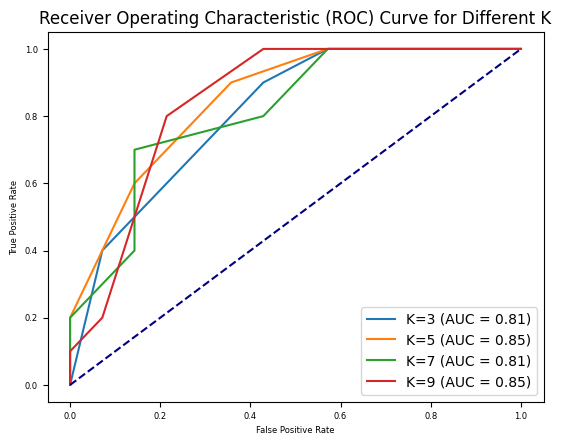

In [34]:
for k in [3,5,7,9]:
    knn = KNeighborsClassifier(n_neighbors=k, metric='manhattan')
    knn.fit(X_train, y_train)
    
    # Previsão de probabilidades
    y_prob = knn.predict_proba(X_test)[:, 1]
    
    # Curva ROC
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = roc_auc_score(y_test, y_prob)
    
    # Plotar a curva ROC para o valor atual de K
    plt.plot(fpr, tpr, label=f'K={k} (AUC = {roc_auc:.2f})')

    cv_scores = cross_val_score(knn, X_train, y_train, cv=4, scoring='accuracy')
    cv_scores1 = cross_val_score(knn, X_train, y_train, cv=4, scoring='average_precision')
    cv_scores2 = cross_val_score(knn, X_train, y_train, cv=4, scoring='f1')
    print(f"\n{k}:Cross-Validation Accuracy: {cv_scores.mean():.2f} ± {cv_scores.std():.2f}")
    print(f"{k}:Cross-Validation Precision: {cv_scores1.mean():.2f} ± {cv_scores1.std():.2f}")
    print(f"{k}:Cross-Validation F1-Score: {cv_scores2.mean():.2f} ± {cv_scores2.std():.2f}")

plt.rcParams.update({'font.size': 10})
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Different K')
plt.legend(loc='lower right')
plt.show()

#### Árvore de Decisão

In [35]:
X = df_norm.drop(columns=['syndromic'])
y = df_norm['syndromic']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [36]:
clf = DecisionTreeClassifier(criterion='entropy', max_depth=3)
clf.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=3)


Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      0.64      0.78        14
         1.0       0.67      1.00      0.80        10

    accuracy                           0.79        24
   macro avg       0.83      0.82      0.79        24
weighted avg       0.86      0.79      0.79        24



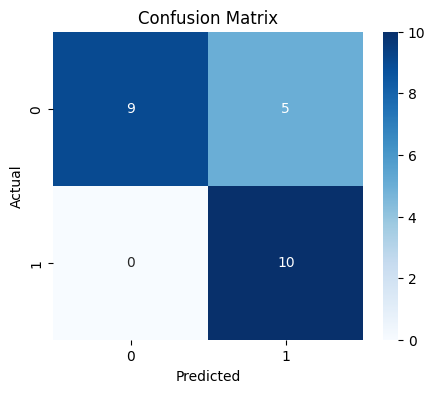

In [37]:
y_pred = clf.predict(X_test)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Matriz de Confusão
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


3:Cross-Validation Accuracy: 0.74 ± 0.09
3:Cross-Validation Average Precision: 0.66 ± 0.05
9:Cross-Validation F1-Score: 0.68 ± 0.23

5:Cross-Validation Accuracy: 0.69 ± 0.07
5:Cross-Validation Average Precision: 0.62 ± 0.08
9:Cross-Validation F1-Score: 0.61 ± 0.18

8:Cross-Validation Accuracy: 0.67 ± 0.04
8:Cross-Validation Average Precision: 0.55 ± 0.08
9:Cross-Validation F1-Score: 0.58 ± 0.10

10:Cross-Validation Accuracy: 0.68 ± 0.02
10:Cross-Validation Average Precision: 0.55 ± 0.05
9:Cross-Validation F1-Score: 0.63 ± 0.08


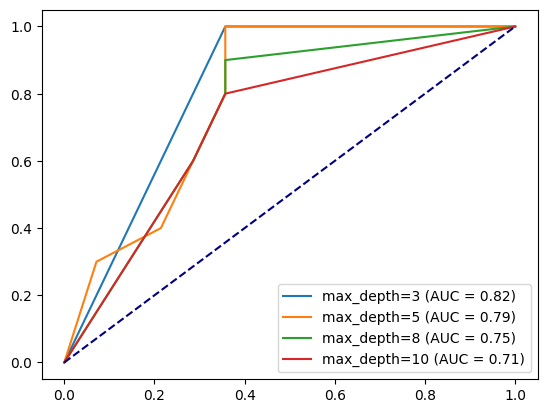

In [38]:
for x in [3,5,8,10]:
    clf = DecisionTreeClassifier(criterion='entropy', max_depth=x)
    clf.fit(X_train, y_train)
    
    # Previsão de probabilidades
    y_prob = clf.predict_proba(X_test)[:, 1]
    
    # Curva ROC
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = roc_auc_score(y_test, y_prob)
    
    # Plotar a curva ROC para o valor atual de K
    plt.plot(fpr, tpr, label=f'max_depth={x} (AUC = {roc_auc:.2f})')
    plt.legend(loc='lower right')
    
    cv_scores = cross_val_score(clf, X_train, y_train, cv=4, scoring='accuracy')
    cv_scores1 = cross_val_score(clf, X_train, y_train, cv=4, scoring='average_precision')
    cv_scores2 = cross_val_score(clf, X_train, y_train, cv=4, scoring='f1')
    print(f"\n{x}:Cross-Validation Accuracy: {cv_scores.mean():.2f} ± {cv_scores.std():.2f}")
    print(f"{x}:Cross-Validation Average Precision: {cv_scores1.mean():.2f} ± {cv_scores1.std():.2f}")
    print(f"{k}:Cross-Validation F1-Score: {cv_scores2.mean():.2f} ± {cv_scores2.std():.2f}")

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

#### Random Forest

In [39]:
ensemble_model = BaggingClassifier(clf, n_estimators=10, random_state=0)

# Treinar o modelo
ensemble_model.fit(X_train, y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(criterion='entropy',
                                                   max_depth=10),
                  random_state=0)


Classification Report:
               precision    recall  f1-score   support

         0.0       0.71      0.71      0.71        14
         1.0       0.60      0.60      0.60        10

    accuracy                           0.67        24
   macro avg       0.66      0.66      0.66        24
weighted avg       0.67      0.67      0.67        24



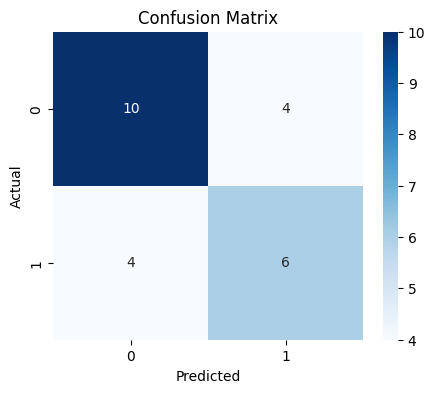

In [40]:
y_pred = ensemble_model.predict(X_test)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Matriz de Confusão
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


3:Cross-Validation Accuracy: 0.69 ± 0.07
3:Cross-Validation Average Precision: 0.64 ± 0.09
3:Cross-Validation F1-Score: 0.62 ± 0.12

5:Cross-Validation Accuracy: 0.69 ± 0.07
5:Cross-Validation Average Precision: 0.67 ± 0.09
5:Cross-Validation F1-Score: 0.64 ± 0.13

10:Cross-Validation Accuracy: 0.71 ± 0.07
10:Cross-Validation Average Precision: 0.69 ± 0.11
10:Cross-Validation F1-Score: 0.67 ± 0.09

20:Cross-Validation Accuracy: 0.72 ± 0.03
20:Cross-Validation Average Precision: 0.72 ± 0.04
20:Cross-Validation F1-Score: 0.68 ± 0.08

40:Cross-Validation Accuracy: 0.71 ± 0.03
40:Cross-Validation Average Precision: 0.75 ± 0.06
40:Cross-Validation F1-Score: 0.67 ± 0.06

100:Cross-Validation Accuracy: 0.71 ± 0.03
100:Cross-Validation Average Precision: 0.74 ± 0.06
100:Cross-Validation F1-Score: 0.66 ± 0.07


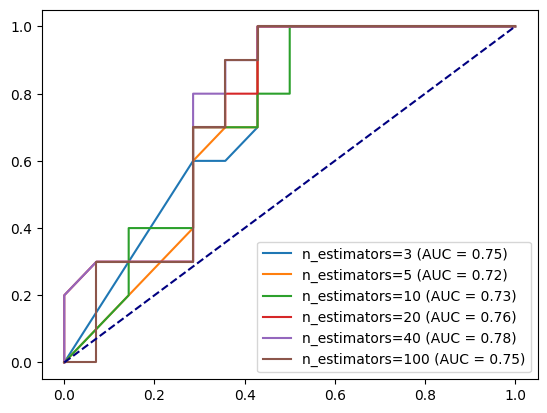

In [41]:
for n in [3,5,10,20,40,100]:
    ensemble_model = BaggingClassifier(clf, n_estimators=n, random_state=0)
    ensemble_model.fit(X_train, y_train)
        
    # Previsão de probabilidades
    y_prob = ensemble_model.predict_proba(X_test)[:, 1]
    
    # Curva ROC
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = roc_auc_score(y_test, y_prob)
    
    # Plotar a curva ROC para o valor atual de K
    plt.plot(fpr, tpr, label=f'n_estimators={n} (AUC = {roc_auc:.2f})')
    plt.legend(loc='lower right')
    
    cv_scores = cross_val_score(ensemble_model, X_train, y_train, cv=4, scoring='accuracy')
    cv_scores1 = cross_val_score(ensemble_model, X_train, y_train, cv=4, scoring='average_precision')
    cv_scores2 = cross_val_score(ensemble_model, X_train, y_train, cv=4, scoring='f1')
    print(f"\n{n}:Cross-Validation Accuracy: {cv_scores.mean():.2f} ± {cv_scores.std():.2f}")
    print(f"{n}:Cross-Validation Average Precision: {cv_scores1.mean():.2f} ± {cv_scores1.std():.2f}")
    print(f"{n}:Cross-Validation F1-Score: {cv_scores2.mean():.2f} ± {cv_scores2.std():.2f}")

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

#### Naive-Bayes
P(b|a) = P(a|b) P(b) </br>
P(b|a^c) = P(a|b) P(c|b) 

In [42]:
nb_classifier = GaussianNB()
nb_classifier.fit(X_train, y_train)

GaussianNB()

Accuracy: 0.79
Precision: 0.67
Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.64      0.78        14
         1.0       0.67      1.00      0.80        10

    accuracy                           0.79        24
   macro avg       0.83      0.82      0.79        24
weighted avg       0.86      0.79      0.79        24



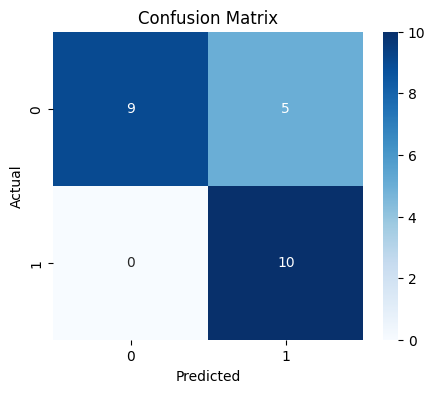

In [43]:
y_pred = nb_classifier.predict(X_test)

# Avaliar o modelo
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')

print("Classification Report:")
print(classification_report(y_test, y_pred))

# Matriz de Confusão
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


10:Cross-Validation Accuracy: 0.82 ± 0.06
10:Cross-Validation Average Precision: 0.72 ± 0.02
9:Cross-Validation F1-Score: 0.83 ± 0.06


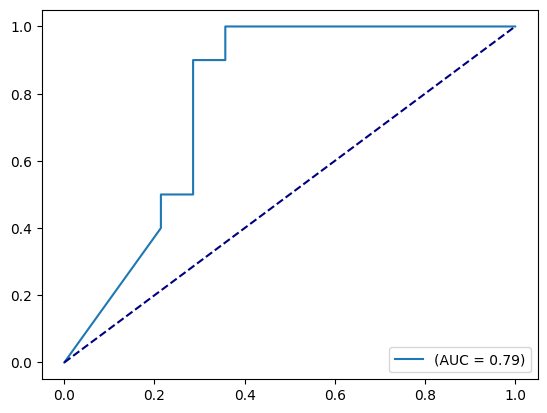

In [44]:
# Previsão de probabilidades
y_prob = nb_classifier.predict_proba(X_test)[:, 1]

# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

# Plotar a curva ROC para o valor atual de K
plt.plot(fpr, tpr, label=f'(AUC = {roc_auc:.2f})')
plt.legend(loc='lower right')

cv_scores = cross_val_score(nb_classifier, X_train, y_train, cv=4, scoring='accuracy')
cv_scores1 = cross_val_score(nb_classifier, X_train, y_train, cv=4, scoring='average_precision')
cv_scores2 = cross_val_score(nb_classifier, X_train, y_train, cv=4, scoring='f1')
print(f"\n{x}:Cross-Validation Accuracy: {cv_scores.mean():.2f} ± {cv_scores.std():.2f}")
print(f"{x}:Cross-Validation Average Precision: {cv_scores1.mean():.2f} ± {cv_scores1.std():.2f}")
print(f"{k}:Cross-Validation F1-Score: {cv_scores2.mean():.2f} ± {cv_scores2.std():.2f}")
    
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

#### Ensemble

In [45]:
base_models = [
    ('decision_tree',DecisionTreeClassifier(criterion='entropy', max_depth=3)),
    ('knn', KNeighborsClassifier(n_neighbors=3, metric='manhattan')),
    ('naive_bayes', GaussianNB())
]

In [46]:
meta_model = AdaBoostClassifier()

In [47]:
stacking_model = StackingClassifier(estimators=base_models, final_estimator=meta_model)

stacking_model.fit(X_train, y_train)

StackingClassifier(estimators=[('decision_tree',
                                DecisionTreeClassifier(criterion='entropy',
                                                       max_depth=3)),
                               ('knn',
                                KNeighborsClassifier(metric='manhattan',
                                                     n_neighbors=3)),
                               ('naive_bayes', GaussianNB())],
                   final_estimator=AdaBoostClassifier())

In [48]:
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      0.64      0.78        14
         1.0       0.67      1.00      0.80        10

    accuracy                           0.79        24
   macro avg       0.83      0.82      0.79        24
weighted avg       0.86      0.79      0.79        24



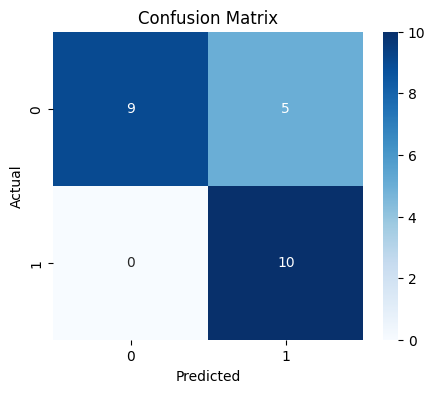

In [49]:
# Matriz de Confusão
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


10:Cross-Validation Accuracy: 0.77 ± 0.05
10:Cross-Validation Average Precision: 0.73 ± 0.07
9:Cross-Validation F1-Score: 0.77 ± 0.07


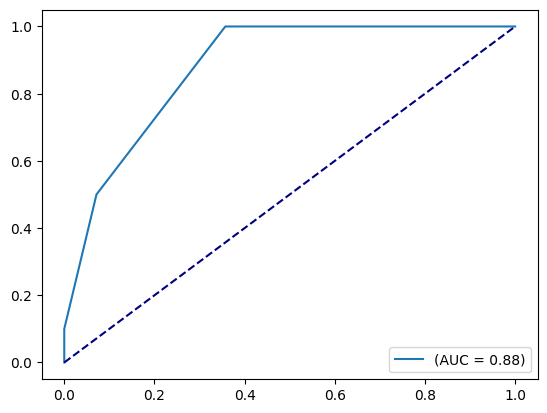

In [50]:
# Previsão de probabilidades
y_prob = stacking_model.predict_proba(X_test)[:, 1]

# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

# Plotar a curva ROC para o valor atual de K
plt.plot(fpr, tpr, label=f'(AUC = {roc_auc:.2f})')
plt.legend(loc='lower right')

cv_scores = cross_val_score(stacking_model, X_train, y_train, cv=4, scoring='accuracy')
cv_scores1 = cross_val_score(stacking_model, X_train, y_train, cv=4, scoring='average_precision')
cv_scores2 = cross_val_score(stacking_model, X_train, y_train, cv=4, scoring='f1')
print(f"\n{x}:Cross-Validation Accuracy: {cv_scores.mean():.2f} ± {cv_scores.std():.2f}")
print(f"{x}:Cross-Validation Average Precision: {cv_scores1.mean():.2f} ± {cv_scores1.std():.2f}")
print(f"{k}:Cross-Validation F1-Score: {cv_scores2.mean():.2f} ± {cv_scores2.std():.2f}")
    
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

#### SVM

In [51]:
svm_model = SVC(C=0.1, kernel='linear', probability=True)
svm_model.fit(X_train, y_train)
y_pred = svm_model.predict(X_test)

print("\nClassification Report:\n", classification_report(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

         0.0       0.82      0.64      0.72        14
         1.0       0.62      0.80      0.70        10

    accuracy                           0.71        24
   macro avg       0.72      0.72      0.71        24
weighted avg       0.73      0.71      0.71        24



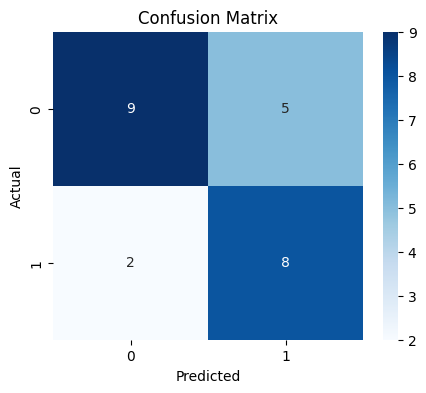

In [52]:
# Matriz de Confusão
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


0.001:Cross-Validation Accuracy: 0.56 ± 0.02
0.001:Cross-Validation Precision: 0.81 ± 0.12
0.001:Cross-Validation F1-Score: 0.00 ± 0.00

0.01:Cross-Validation Accuracy: 0.56 ± 0.02
0.01:Cross-Validation Precision: 0.81 ± 0.12
0.01:Cross-Validation F1-Score: 0.00 ± 0.00

0.1:Cross-Validation Accuracy: 0.70 ± 0.11
0.1:Cross-Validation Precision: 0.86 ± 0.08
0.1:Cross-Validation F1-Score: 0.60 ± 0.27

1:Cross-Validation Accuracy: 0.69 ± 0.10
1:Cross-Validation Precision: 0.76 ± 0.17
1:Cross-Validation F1-Score: 0.59 ± 0.26

10:Cross-Validation Accuracy: 0.68 ± 0.11
10:Cross-Validation Precision: 0.69 ± 0.12
10:Cross-Validation F1-Score: 0.59 ± 0.26

100:Cross-Validation Accuracy: 0.68 ± 0.11
100:Cross-Validation Precision: 0.65 ± 0.09
100:Cross-Validation F1-Score: 0.59 ± 0.26

1000:Cross-Validation Accuracy: 0.68 ± 0.11
1000:Cross-Validation Precision: 0.70 ± 0.12
1000:Cross-Validation F1-Score: 0.59 ± 0.26

10000:Cross-Validation Accuracy: 0.68 ± 0.11
10000:Cross-Validation Precision: 

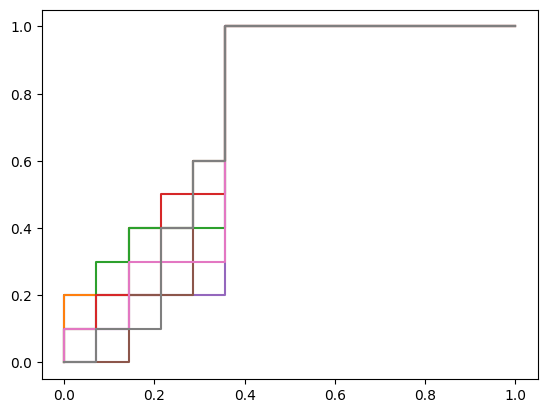

In [53]:
for c in [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]:
    svm_model = SVC(C=c, kernel='linear', probability=True)
    svm_model.fit(X_train, y_train)

    # Previsão de probabilidades
    y_prob = svm_model.predict_proba(X_test)[:, 1]
    
    # Curva ROC
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = roc_auc_score(y_test, y_prob)
    
    # Plotar a curva ROC para o valor atual de K
    plt.plot(fpr, tpr, label=f'C={c} (AUC = {roc_auc:.2f})')

    cv_scores = cross_val_score(svm_model, X_train, y_train, cv=4, scoring='accuracy')
    cv_scores1 = cross_val_score(svm_model, X_train, y_train, cv=4, scoring='average_precision')
    cv_scores2 = cross_val_score(svm_model, X_train, y_train, cv=4, scoring='f1')
    print(f"\n{c}:Cross-Validation Accuracy: {cv_scores.mean():.2f} ± {cv_scores.std():.2f}")
    print(f"{c}:Cross-Validation Precision: {cv_scores1.mean():.2f} ± {cv_scores1.std():.2f}")
    print(f"{c}:Cross-Validation F1-Score: {cv_scores2.mean():.2f} ± {cv_scores2.std():.2f}")

#plt.rcParams.update({'font.size': 10})
#plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
#plt.xlabel('False Positive Rate')
#plt.ylabel('True Positive Rate')
#plt.title('Receiver Operating Characteristic (ROC) Curve for Different K')
#plt.legend(loc='lower right')
#plt.show()

#### Redes Neurais Artificiais

In [54]:
# LBFGS:  Descrição: Otimizador baseado em uma variação do método de Newton. Funciona bem em datasets pequenos a médios.
#         Vantagens: Pode ser mais preciso que o 'adam' em certos problemas, especialmente quando a precisão da solução é importante.
#         Quando Usar: Útil em problemas onde o dataset é pequeno e se deseja uma solução mais exata.
# Weight optmization

mlp = MLPClassifier(hidden_layer_sizes=(3,), max_iter=500, random_state=0, activation='relu')
mlp.solver = 'lbfgs'
mlp.fit(X_train, y_train)

y_pred = mlp.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

         0.0       0.90      0.64      0.75        14
         1.0       0.64      0.90      0.75        10

    accuracy                           0.75        24
   macro avg       0.77      0.77      0.75        24
weighted avg       0.79      0.75      0.75        24



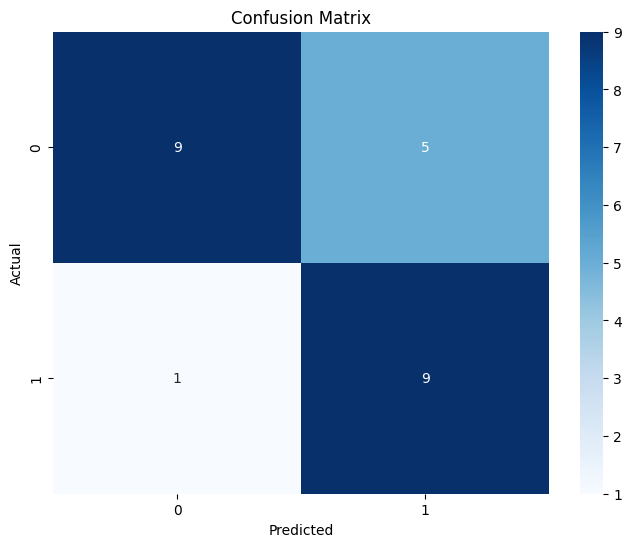

In [55]:
# Matriz de Confusão
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


10:Cross-Validation Accuracy: 0.75 ± 0.03
10:Cross-Validation Average Precision: 0.81 ± 0.01
9:Cross-Validation F1-Score: 0.74 ± 0.03


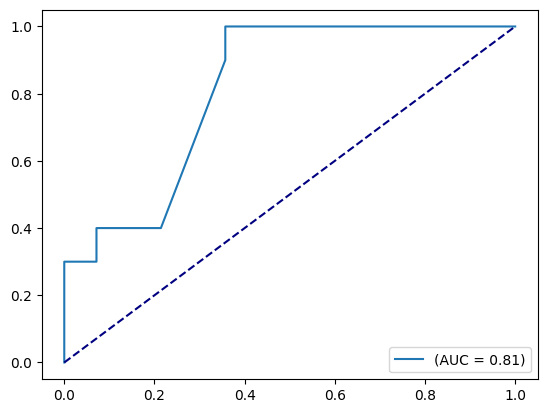

In [56]:
# Previsão de probabilidades
y_prob = mlp.predict_proba(X_test)[:, 1]

# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

# Plotar a curva ROC para o valor atual de K
plt.plot(fpr, tpr, label=f'(AUC = {roc_auc:.2f})')
plt.legend(loc='lower right')

cv_scores = cross_val_score(mlp, X_train, y_train, cv=4, scoring='accuracy')
cv_scores1 = cross_val_score(mlp, X_train, y_train, cv=4, scoring='average_precision')
cv_scores2 = cross_val_score(mlp, X_train, y_train, cv=4, scoring='f1')
print(f"\n{x}:Cross-Validation Accuracy: {cv_scores.mean():.2f} ± {cv_scores.std():.2f}")
print(f"{x}:Cross-Validation Average Precision: {cv_scores1.mean():.2f} ± {cv_scores1.std():.2f}")
print(f"{k}:Cross-Validation F1-Score: {cv_scores2.mean():.2f} ± {cv_scores2.std():.2f}")
    
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

#### CNN

In [57]:
X = df_norm.drop(columns=['syndromic'])
y = df_norm['syndromic']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled = X_scaled.reshape(X_scaled.shape[0], X_scaled.shape[1], 1)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=0)

In [58]:
model = Sequential()
model.add(Conv1D(filters=16, kernel_size=3, activation='relu',
                 input_shape=(X_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # Saída binária

# Compilar o modelo
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

C:\Users\igora\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [59]:
history = model.fit(X_train, y_train, epochs=40, batch_size=32, validation_split=0.2)

Epoch 1/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.4673 - loss: 0.7052 - val_accuracy: 0.5500 - val_loss: 0.6832
Epoch 2/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5993 - loss: 0.6793 - val_accuracy: 0.5500 - val_loss: 0.6755
Epoch 3/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6793 - loss: 0.6790 - val_accuracy: 0.7000 - val_loss: 0.6674
Epoch 4/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6832 - loss: 0.6667 - val_accuracy: 0.7000 - val_loss: 0.6607
Epoch 5/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6834 - loss: 0.6620 - val_accuracy: 0.7000 - val_loss: 0.6547
Epoch 6/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7658 - loss: 0.6531 - val_accuracy: 0.7000 - val_loss: 0.6493
Epoch 7/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7773 - loss: 0.6382 - val_accuracy: 0.7500 - val_loss: 0.6439
Epoch 8/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7368 - loss: 0.6297 - val_accuracy: 0.8000 - val_loss: 0.6386


In [60]:
# Fazer previsões no conjunto de teste
y_pred_proba = model.predict(X_test)
y_pred = (y_pred_proba > 0.5).astype(int)

# Avaliar o modelo
print("Accuracy do modelo:", accuracy_score(y_test, y_pred))
print("\nClassification Report do modelo:\n", classification_report(y_test, y_pred))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Accuracy do modelo: 0.875

Classification Report do modelo:
               precision    recall  f1-score   support

         0.0       0.92      0.86      0.89        14
         1.0       0.82      0.90      0.86        10

    accuracy                           0.88        24
   macro avg       0.87      0.88      0.87        24
weighted avg       0.88      0.88      0.88        24



In [78]:
from PIL import ImageFont
visualkeras.layered_view(model).show() # display using your system viewer
visualkeras.layered_view(model, to_file='output.png', draw_volume=True, legend=True) # write to disk
visualkeras.layered_view(model, to_file='output.png', draw_volume=True, legend=True).show() # write and show

In [86]:
kf = KFold(n_splits=4, shuffle=True, random_state=42)
auc_scores = []

# Loop para cada fold
for train_index, test_index in kf.split(X_scaled):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Criar e treinar o modelo
    model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)
    
    # Fazer previsões
    y_pred_proba = model.predict(X_test).ravel()  # Previsões de probabilidade
    
    # Calcular AUC
    auc = roc_auc_score(y_test, y_pred_proba)
    auc_scores.append(auc)
    
    print(f'Fold AUC: {auc:.4f}')

# Mostrar resultados da validação cruzada
print(f'Média AUC: {np.mean(auc_scores):.4f}')
print(f'Desvio padrão da AUC: {np.std(auc_scores):.4f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Fold AUC: 0.9022
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Fold AUC: 0.8624
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Fold AUC: 0.8125
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Fold AUC: 0.8929
Média AUC: 0.8675
Desvio padrão da AUC: 0.0350


### Não Supervisionado

#### K-Means

In [62]:
X = df_norm.drop(columns=['syndromic'])
y = df_norm['syndromic']

In [63]:
kmeans = KMeans(n_clusters=2, init='random', n_init=6, random_state=0)  # Defina o número de clusters desejado
clusters = kmeans.fit_predict(X)

In [64]:
# Avaliação com o índice de silhueta
silhouette_avg = silhouette_score(X, clusters)
print(f'Índice de Silhueta: {silhouette_avg:.3f}')

# Avaliação com o índice de Jaccard (comparando os clusters com a coluna binária original)
jaccard_avg = jaccard_score(y, clusters, average='macro')
print(f'Índice de Jaccard: {jaccard_avg:.3f}')

Índice de Silhueta: 0.228
Índice de Jaccard: 0.323


In [65]:
df_kmeans = df_norm
df_kmeans['cluster'] = clusters
count_syndromic = df_kmeans.groupby(['cluster', 'syndromic']).size().unstack(fill_value=0)

print(count_syndromic)

syndromic  0.0  1.0
cluster            
0           35   28
1           33   24


In [66]:
# Calcular o índice de silhueta para cada amostra
silhouette_vals = silhouette_samples(X, clusters)

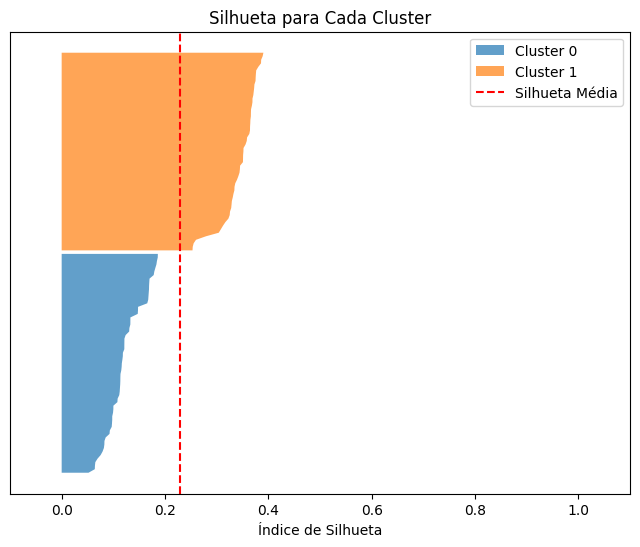

In [67]:
# Criar o gráfico
fig, ax = plt.subplots(figsize=(8, 6))
y_lower, y_upper = 0, 0
for i in range(2):  # Substitua 3 pelo número de clusters
    cluster_silhouette_vals = silhouette_vals[clusters == i]
    cluster_silhouette_vals.sort()
    y_upper += len(cluster_silhouette_vals)
    ax.fill_betweenx(np.arange(y_lower, y_upper),
                      0, cluster_silhouette_vals,
                      alpha=0.7, label=f'Cluster {i}')
    y_lower += len(cluster_silhouette_vals)

ax.axvline(x=silhouette_score(X, clusters), color='red', linestyle='--', label='Silhueta Média')
ax.set_xlim(-0.1, 1.1)
ax.set_yticks([])
ax.set_xlabel('Índice de Silhueta')
ax.set_title('Silhueta para Cada Cluster')
ax.legend()
plt.show()

#### Complete-link

In [68]:
df_link = df_norm
X = df_link.drop(columns=['syndromic'])
y = df_link['syndromic']
Z = linkage(X, method='average')

In [69]:
# Definir o número de clusters
k = 2  # Ajuste de acordo com a sua necessidade

# Atribuir clusters ao dataset
clusters = fcluster(Z, k, criterion='maxclust')

# Adicionar os rótulos de cluster ao DataFrame
df_link['Cluster'] = clusters

In [70]:
count_syndromic = df_kmeans.groupby(['cluster', 'syndromic']).size().unstack(fill_value=0)

print(count_syndromic)

syndromic  0.0  1.0
cluster            
0           35   28
1           33   24


In [71]:
# Avaliação com o índice de silhueta
silhouette_avg = silhouette_score(X, clusters)
print(f'Índice de Silhueta: {silhouette_avg:.3f}')

# Avaliação com o índice de Jaccard (comparando os clusters com a coluna binária original)
jaccard_avg = jaccard_score(y, clusters, average='macro')
print(f'Índice de Jaccard: {jaccard_avg:.3f}')

Índice de Silhueta: 0.315
Índice de Jaccard: 0.094
